In [135]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [136]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from gmvae import GMVAE
from circular_vae import CircularVAE
from base_vae import BaseVAE
from vae import VAE
from utils import *
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

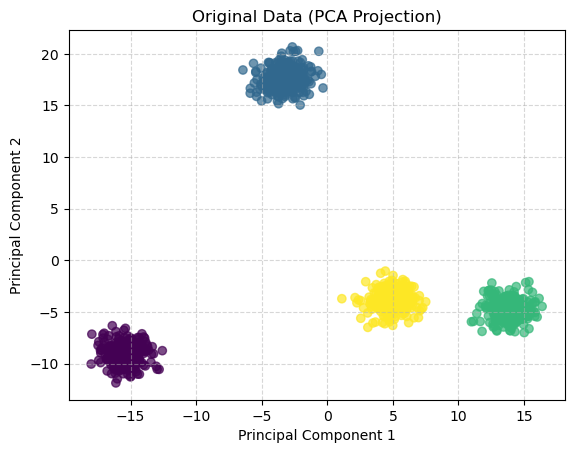

In [137]:
# --- 1. Generate Synthetic Data ---
n_samples = 1000
n_features = 50
centers = 4

X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, random_state=42)
X = np.abs(X).astype(np.int32).astype(np.float32) # Make counts positive 
row_sums = X.sum(axis=1)
keep_indices = row_sums > 0
X = X[keep_indices]
y = y[keep_indices]
# X = StandardScaler().fit_transform(X) # Scale for stability
X_tensor = torch.tensor(X, dtype=torch.float32)
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_tensor) # Use the numpy array X before it becomes a tensor
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title("Original Data (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [138]:
# --- 2. Initialize Model ---
n_latent = 1
# Use blob centers as the fixed means for the prior
fixed_means = torch.tensor([-2,-1, 0 , 1], dtype=torch.float32)
print("fixed means", fixed_means)
model = GMVAE(
    n_input=n_features,
    n_latent=n_latent,
    fixed_means=fixed_means
)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
print(f"Data shape after filtering: {X_tensor.shape}")
print(f"Minimum value in data: {X_tensor.min().item()}")

fixed means tensor([-2., -1.,  0.,  1.])
Data shape after filtering: torch.Size([1000, 50])
Minimum value in data: 0.0


In [142]:
# KL Annealing parameters
# NOTE: KL annealing logic (scheduling kl_weight) is an application-level concern,
# not a model-internal concern. It is best kept here, not inside the model class.
# The model class should accept kl_weight as an argument to its loss function,
# but the scheduling/annealing of kl_weight is a training/application decision.

n_epochs = 500
n_warmup_epochs = 20 # The first 50 epochs will be the "grace period"
kl_weight = 0.0

# Lists for plotting loss later
loss_history = []
kl_weight_history = []


for epoch in range(n_epochs):
    model.train()
    
    # --- Calculate the KL weight for this epoch ---
    # Linearly increase weight from 0 to 1 over the warmup period
    if epoch < n_warmup_epochs:
        kl_weight = 2.0 * epoch / n_warmup_epochs
    else:
        kl_weight = 2.0
    
    kl_weight_history.append(kl_weight)
    # ---------------------------------------------

    optimizer.zero_grad()
    
    forward_output = model(X_tensor)
    # --- Pass the kl_weight to the loss function ---
    loss_dict = model.loss(X_tensor, forward_output, kl_weight=kl_weight)
    
    loss = loss_dict["loss"]
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Keep gradient clipping
    optimizer.step()
    
    loss_history.append(loss.item())

    if (epoch + 1) % 20 == 0:
        print(
            f"Epoch [{epoch+1}/{n_epochs}], "
            f"Loss: {loss.item():.4f}, "
            f"KL Weight: {kl_weight:.2f}, "
            f"Recon Loss: {loss_dict['recon_loss']:.4f}, "
            f"KL Local: {loss_dict['kl_local']:.4f}"
        )

Epoch [20/500], Loss: 106.6810, KL Weight: 1.90, Recon Loss: 89.7706, KL Local: 8.9002
Epoch [40/500], Loss: 107.2382, KL Weight: 2.00, Recon Loss: 90.4538, KL Local: 8.3922
Epoch [60/500], Loss: 106.8736, KL Weight: 2.00, Recon Loss: 89.8227, KL Local: 8.5254
Epoch [80/500], Loss: 106.7242, KL Weight: 2.00, Recon Loss: 89.8116, KL Local: 8.4563
Epoch [100/500], Loss: 106.8764, KL Weight: 2.00, Recon Loss: 89.9105, KL Local: 8.4830
Epoch [120/500], Loss: 106.5281, KL Weight: 2.00, Recon Loss: 89.5698, KL Local: 8.4791
Epoch [140/500], Loss: 106.5199, KL Weight: 2.00, Recon Loss: 89.5398, KL Local: 8.4900
Epoch [160/500], Loss: 106.3732, KL Weight: 2.00, Recon Loss: 89.4488, KL Local: 8.4622
Epoch [180/500], Loss: 106.2160, KL Weight: 2.00, Recon Loss: 89.2682, KL Local: 8.4739
Epoch [200/500], Loss: 106.2020, KL Weight: 2.00, Recon Loss: 89.2556, KL Local: 8.4732
Epoch [220/500], Loss: 106.2182, KL Weight: 2.00, Recon Loss: 89.3493, KL Local: 8.4344
Epoch [240/500], Loss: 106.1373, KL 

Statistics for each cluster:
Cluster 0: mean=-0.100, std=0.068, min=-0.272, max=0.061
Cluster 1: mean=0.513, std=0.076, min=0.313, max=0.699
Cluster 2: mean=-1.340, std=0.091, min=-1.580, max=-1.090
Cluster 3: mean=-0.701, std=0.074, min=-0.919, max=-0.515


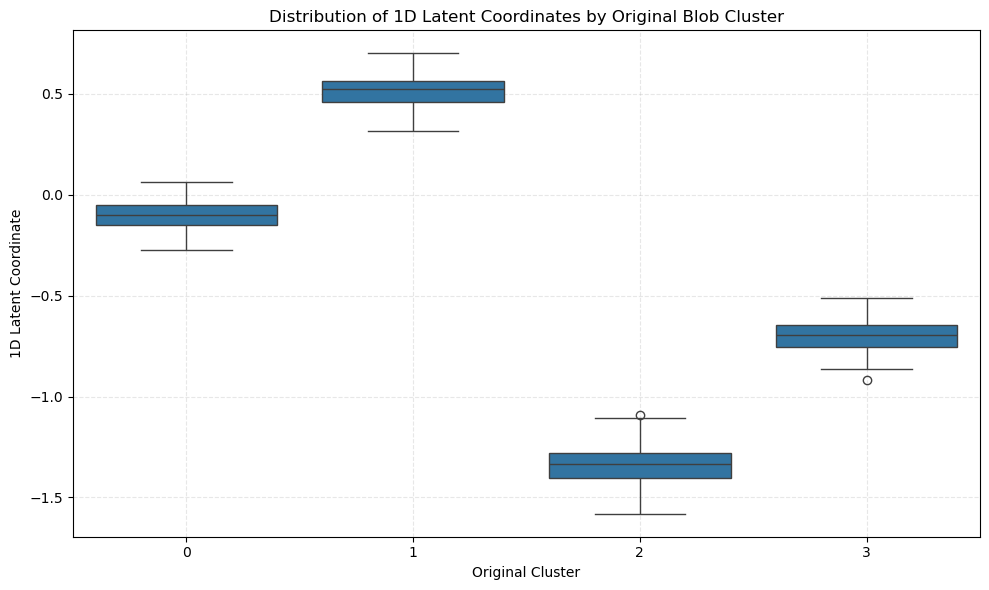

In [143]:
# --- 3. Extract Latent Representations and Create Multi-Box Plot ---
model.eval()
with torch.no_grad():
    # Get the latent representations
    forward_output = model(X_tensor)
    z = forward_output['z']  # This should be the 1D latent representation
    
# Convert to numpy for plotting
z_np = z.numpy().flatten()

# Create a DataFrame for easier plotting
import pandas as pd
import seaborn as sns

# Create DataFrame with latent coordinates and original cluster labels
df = pd.DataFrame({
    'latent_coord': z_np,
    'original_cluster': y
})

# Create the multi-box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='original_cluster', y='latent_coord')
plt.title('Distribution of 1D Latent Coordinates by Original Blob Cluster')
plt.xlabel('Original Cluster')
plt.ylabel('1D Latent Coordinate')
plt.grid(True, linestyle='--', alpha=0.3)

# Add some statistics
print("Statistics for each cluster:")
for cluster in sorted(df['original_cluster'].unique()):
    cluster_data = df[df['original_cluster'] == cluster]['latent_coord']
    print(f"Cluster {cluster}: mean={cluster_data.mean():.3f}, std={cluster_data.std():.3f}, "
          f"min={cluster_data.min():.3f}, max={cluster_data.max():.3f}")

plt.tight_layout()
plt.show()


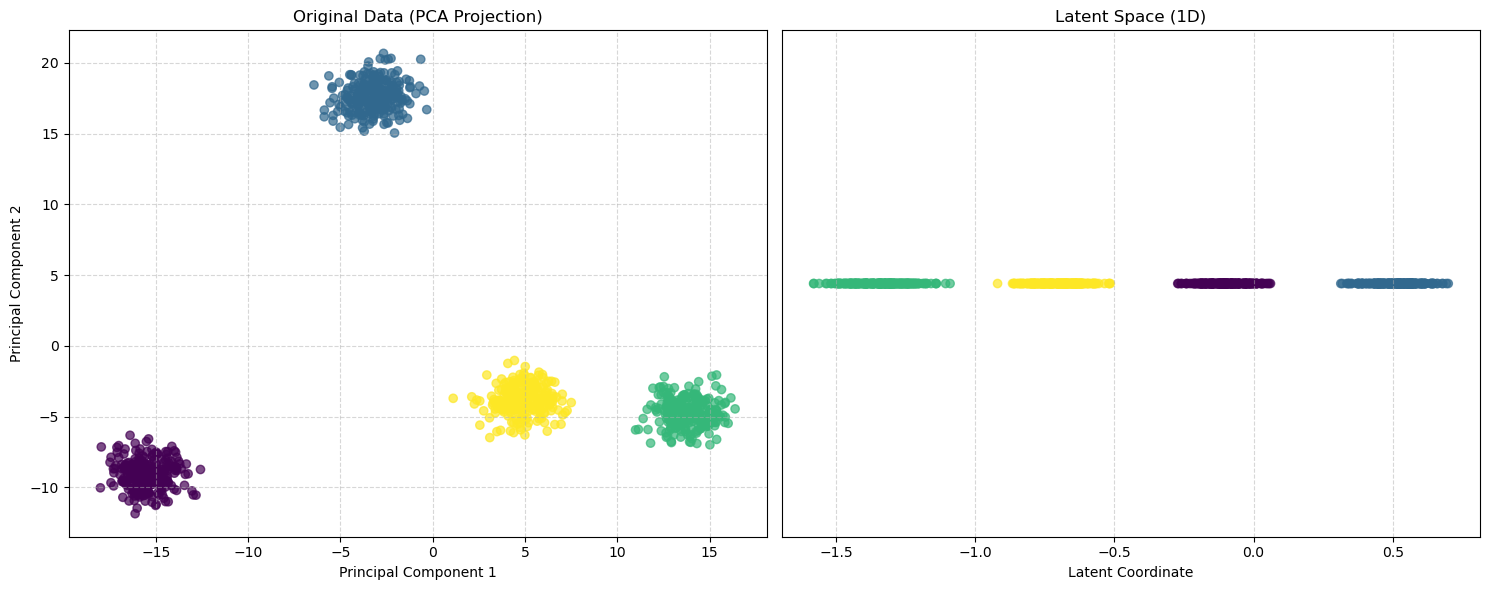


Fixed means used in the model: [-2. -1.  0.  1.]
Number of samples per cluster:
Cluster 0: 250 samples
Cluster 1: 250 samples
Cluster 2: 250 samples
Cluster 3: 250 samples


In [144]:
# --- 4. Additional Visualizations ---
# Create a side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original PCA visualization
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
ax1.set_title("Original Data (PCA Projection)")
ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
ax1.grid(True, linestyle='--', alpha=0.5)

# Latent space visualization (1D projected onto 2D for visualization)
# Create a 2D scatter plot where x=latent_coord and y=0 (or some other constant)
ax2.scatter(z_np, np.zeros_like(z_np), c=y, cmap='viridis', alpha=0.7)
ax2.set_title("Latent Space (1D)")
ax2.set_xlabel("Latent Coordinate")
ax2.set_ylabel("")
ax2.set_yticks([])  # Remove y-axis ticks since it's 1D
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Show the relationship between original clusters and latent coordinates
print(f"\nFixed means used in the model: {fixed_means.numpy()}")
print(f"Number of samples per cluster:")
for cluster in sorted(np.unique(y)):
    count = np.sum(y == cluster)
    print(f"Cluster {cluster}: {count} samples")


In [105]:
def generate_s_curve_data(n_samples=1000, n_features=50, noise=0.5):
    """
    Generates a high-dimensional S-curve dataset with a single non-linear trajectory.
    """
    # 1. Create the ground-truth trajectory (pseudo_time)
    pseudo_time = np.linspace(0, 1, n_samples)
    
    # 2. Embed the trajectory non-linearly into high-dimensional space
    # We use a mix of sine, cosine, and Gaussian bumps to make it complex
    X = np.zeros((n_samples, n_features))
    for i in range(n_features):
        freq = i * 2 + 1
        phase = i * np.pi / 2
        if i % 3 == 0: # Sine wave features
            X[:, i] = np.sin(pseudo_time * freq + phase)
        elif i % 3 == 1: # Gaussian bump features (activity in the middle)
            center = 0.5
            width = 0.1
            X[:, i] = np.exp(-(pseudo_time - center)**2 / width) * 2 - 1
        else: # Polynomial features
            X[:, i] = (pseudo_time * 2 - 1)**(i % 5 + 1)

    # 3. Add noise
    X += np.random.normal(0, noise, X.shape)
    
    # 4. Convert to non-negative "counts" for the NB loss
    X = np.abs(X * 10).astype(np.int32).astype(np.float32)

    # Return the data and the ground-truth pseudo_time for coloring/validation
    return X, pseudo_time

In [106]:
X_sim, pseudo_time = generate_s_curve_data(n_samples=1000)
X_tensor = torch.tensor(X_sim, dtype=torch.float32)

In [107]:
n_latent = 1

# 2. Define a 1D prior with three components for "start", "middle", and "end"
fixed_means = torch.tensor([
    [-4.0],  # "Start" of trajectory
    [0.0],   # "Middle" of trajectory
    [4.0]    # "End" of trajectory
], dtype=torch.float32)

# 3. Initialize and train your model as before
# (Using KL annealing is highly recommended)
model = GMVAE(
    n_input=X_sim.shape[1],
    n_latent=n_latent,
    fixed_means=fixed_means
)

In [114]:
# KL Annealing parameters
# NOTE: KL annealing logic (scheduling kl_weight) is an application-level concern,
# not a model-internal concern. It is best kept here, not inside the model class.
# The model class should accept kl_weight as an argument to its loss function,
# but the scheduling/annealing of kl_weight is a training/application decision.

n_epochs = 500
n_warmup_epochs = 50 # The first 50 epochs will be the "grace period"
kl_weight = 0.0
prior_weight = 10.0
# Lists for plotting loss later
loss_history = []
kl_weight_history = []


for epoch in range(n_epochs):
    model.train()
    
    # --- Calculate the KL weight for this epoch ---
    # Linearly increase weight from 0 to 1 over the warmup period
    if epoch < n_warmup_epochs:
        kl_weight = prior_weight * epoch / n_warmup_epochs
    else:
        kl_weight = prior_weight
    
    kl_weight_history.append(kl_weight)
    # ---------------------------------------------

    optimizer.zero_grad()
    
    forward_output = model(X_tensor)
    # --- Pass the kl_weight to the loss function ---
    loss_dict = model.loss(X_tensor, forward_output, kl_weight=kl_weight)
    
    loss = loss_dict["loss"]
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Keep gradient clipping
    optimizer.step()
    
    loss_history.append(loss.item())

    if (epoch + 1) % 20 == 0:
        print(
            f"Epoch [{epoch+1}/{n_epochs}], "
            f"Loss: {loss.item():.4f}, "
            f"KL Weight: {kl_weight:.2f}, "
            f"Recon Loss: {loss_dict['recon_loss']:.4f}, "
            f"KL Local: {loss_dict['kl_local']:.4f}"
        )

Epoch [20/500], Loss: 145.3810, KL Weight: 3.80, Recon Loss: 142.2126, KL Local: 0.8338
Epoch [40/500], Loss: 148.8993, KL Weight: 7.80, Recon Loss: 142.2080, KL Local: 0.8579
Epoch [60/500], Loss: 150.5679, KL Weight: 10.00, Recon Loss: 142.1978, KL Local: 0.8370
Epoch [80/500], Loss: 150.4490, KL Weight: 10.00, Recon Loss: 142.2103, KL Local: 0.8239
Epoch [100/500], Loss: 150.8134, KL Weight: 10.00, Recon Loss: 142.2166, KL Local: 0.8597
Epoch [120/500], Loss: 150.3989, KL Weight: 10.00, Recon Loss: 142.1936, KL Local: 0.8205
Epoch [140/500], Loss: 150.5388, KL Weight: 10.00, Recon Loss: 142.1758, KL Local: 0.8363
Epoch [160/500], Loss: 150.6045, KL Weight: 10.00, Recon Loss: 142.1887, KL Local: 0.8416
Epoch [180/500], Loss: 150.8898, KL Weight: 10.00, Recon Loss: 142.1588, KL Local: 0.8731
Epoch [200/500], Loss: 150.8323, KL Weight: 10.00, Recon Loss: 142.2419, KL Local: 0.8590
Epoch [220/500], Loss: 150.4681, KL Weight: 10.00, Recon Loss: 142.2043, KL Local: 0.8264
Epoch [240/500],

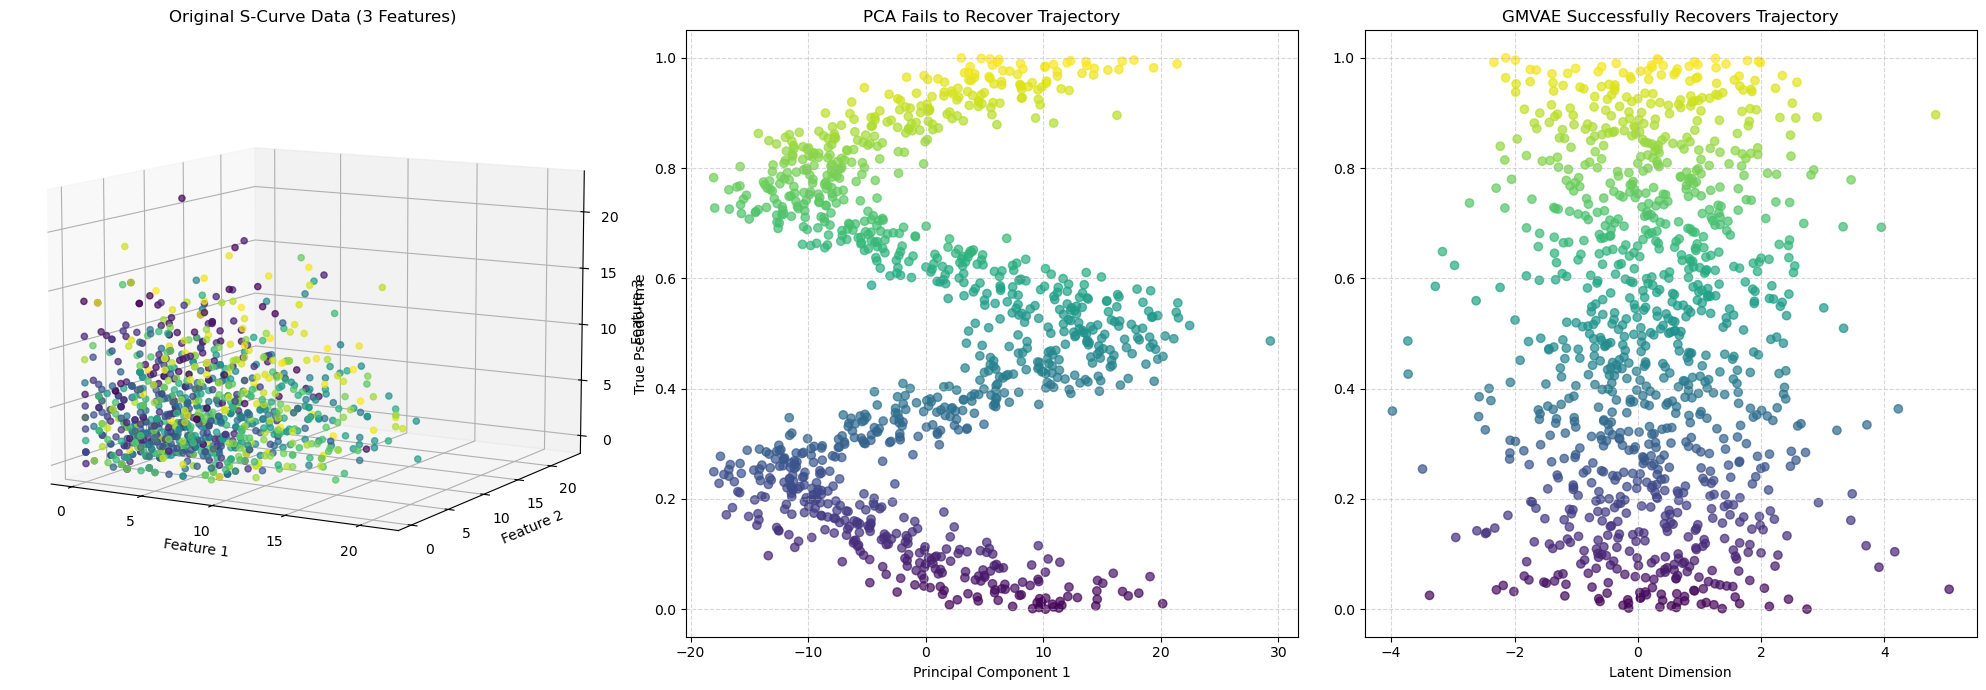

In [115]:
# --- 4. Visualize Original S-Curve and Trajectory Recovery ---
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D # For 3D plotting

# Get the VAE's 1D latent space
model.eval()
with torch.no_grad():
    latent_space = model(X_tensor)["z"].numpy().flatten()

# Get PCA's 1D projection
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_sim).flatten() # Ensure it's 1D for plotting

# Create a figure with 3 subplots
fig = plt.figure(figsize=(20, 7))

# --- Subplot 1: Original S-Curve (3D) ---
ax1 = fig.add_subplot(131, projection='3d') # 1 row, 3 columns, 1st subplot
# Pick three arbitrary features to show the 3D structure.
# Features X_sim[:,0], X_sim[:,1], X_sim[:,2] often capture the S-shape well.
ax1.scatter(X_sim[:, 0], X_sim[:, 1], X_sim[:, 2], c=pseudo_time, cmap='viridis', alpha=0.7)
ax1.set_title("Original S-Curve Data (3 Features)")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_zlabel("Feature 3")
ax1.view_init(elev=10, azim=-60) # Adjust view angle for better S-shape visibility


# --- Subplot 2: PCA Fails to Recover Trajectory ---
ax2 = fig.add_subplot(132) # 1 row, 3 columns, 2nd subplot
ax2.scatter(X_pca, pseudo_time, c=pseudo_time, cmap='viridis', alpha=0.7)
ax2.set_title("PCA Fails to Recover Trajectory")
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("True Pseudo-time")
ax2.grid(True, linestyle='--', alpha=0.5)

# Plot 2: VAE Successfully Recovers Trajectory
ax3 = fig.add_subplot(133) # 1 row, 3 columns, 3rd subplot
ax3.scatter(latent_space, pseudo_time, c=pseudo_time, cmap='viridis', alpha=0.7)
ax3.set_title("GMVAE Successfully Recovers Trajectory")
ax3.set_xlabel("Latent Dimension")
ax3.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout() # Adjust subplot parameters for a tight layout.
plt.show()

S-curve data shape: (1000, 50)
S-curve data range: [0.000, 13.000]


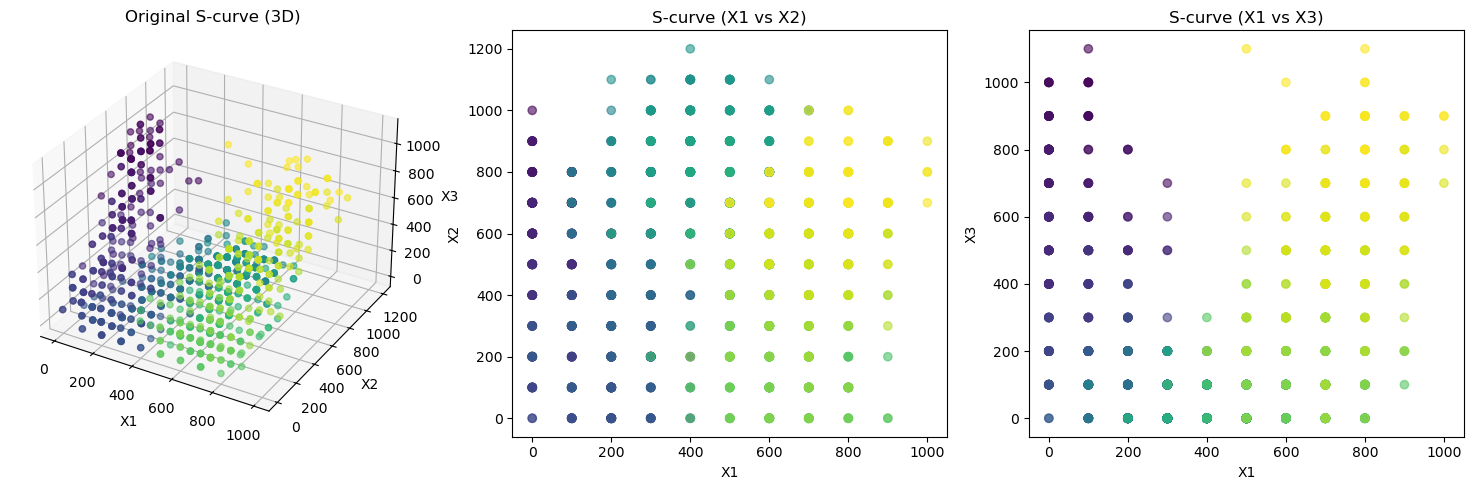

Data statistics:
- Shape: torch.Size([1000, 50])
- Min value: 0.000
- Max value: 1300.000
- Mean value: 458.042
- Std value: 331.352


In [119]:
n_samples = 1000
noise = 0.1
X_s, y_s = generate_s_curve_data(n_samples=n_samples, noise=noise)
print(f"S-curve data shape: {X_s.shape}")
print(f"S-curve data range: [{X_s.min():.3f}, {X_s.max():.3f}]")

# Convert to positive counts (simulate gene expression data)
X_s = np.abs(X_s) * 100  # Scale up
X_s = X_s.astype(np.int32).astype(np.float32)  # Convert to counts
X_s_tensor = torch.tensor(X_s, dtype=torch.float32)

# Visualize original S-curve
fig = plt.figure(figsize=(15, 5))

# 3D plot of original S-curve
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X_s[:, 0], X_s[:, 1], X_s[:, 2], c=y_s, cmap='viridis', alpha=0.6)
ax1.set_title('Original S-curve (3D)')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2') 
ax1.set_zlabel('X3')

# 2D projections
ax2 = fig.add_subplot(132)
ax2.scatter(X_s[:, 0], X_s[:, 1], c=y_s, cmap='viridis', alpha=0.6)
ax2.set_title('S-curve (X1 vs X2)')
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')

ax3 = fig.add_subplot(133)
ax3.scatter(X_s[:, 0], X_s[:, 2], c=y_s, cmap='viridis', alpha=0.6)
ax3.set_title('S-curve (X1 vs X3)')
ax3.set_xlabel('X1')
ax3.set_ylabel('X3')

plt.tight_layout()
plt.show()

print(f"Data statistics:")
print(f"- Shape: {X_s_tensor.shape}")
print(f"- Min value: {X_s_tensor.min():.3f}")
print(f"- Max value: {X_s_tensor.max():.3f}")
print(f"- Mean value: {X_s_tensor.mean():.3f}")
print(f"- Std value: {X_s_tensor.std():.3f}")


In [120]:
# --- Train VAE on S-curve Data ---
print("=== Training VAE on S-curve Data ===\n")

# Set up device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Create VAE model with 2D latent space for visualization
model_s = VAE(
    n_input=X_s_tensor.shape[1],  # 3 features from S-curve
    n_latent=2,                    # 2D latent space for visualization
    n_hidden=64,                   # Smaller hidden size for 3D input
    n_layers=2
).to(device)

print(f"Model architecture:")
print(f"- Input dimension: {X_s_tensor.shape[1]}")
print(f"- Latent dimension: 2")
print(f"- Hidden size: 64")
print(f"- Number of parameters: {sum(p.numel() for p in model_s.parameters()):,}")

# Create data loader
batch_size = 128
data_loader = DataLoader(
    TensorDataset(X_s_tensor), 
    batch_size=batch_size, 
    shuffle=True
)

# Training setup
optimizer = torch.optim.Adam(model_s.parameters(), lr=1e-3, weight_decay=1e-5)
n_epochs = 150
kl_warmup = 20

# Training loop
model_s.train()
loss_history = []
kl_weight_history = []

print(f"\nStarting training for {n_epochs} epochs...")
for epoch in range(1, n_epochs + 1):
    # KL weight annealing
    kl_weight = min(1.0, epoch / kl_warmup)
    kl_weight_history.append(kl_weight)
    
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    n_batches = 0
    
    for batch_x, in data_loader:
        batch_x = batch_x.to(device)
        
        # Forward pass
        forward_output = model_s(batch_x)
        loss_dict = model_s.loss(batch_x, forward_output, kl_weight=kl_weight)
        
        # Backward pass
        optimizer.zero_grad()
        loss_dict["loss"].backward()
        torch.nn.utils.clip_grad_norm_(model_s.parameters(), 5.0)
        optimizer.step()
        
        # Track losses
        total_loss += loss_dict["loss"].item()
        total_recon += loss_dict["recon_loss"].item()
        total_kl += loss_dict["kl_local"].item()
        n_batches += 1
    
    # Record average losses
    avg_loss = total_loss / n_batches
    avg_recon = total_recon / n_batches
    avg_kl = total_kl / n_batches
    loss_history.append({
        'epoch': epoch,
        'loss': avg_loss,
        'recon': avg_recon,
        'kl': avg_kl,
        'kl_weight': kl_weight
    })
    
    # Print progress
    if epoch == 1 or epoch % 25 == 0 or epoch == n_epochs:
        print(f"Epoch [{epoch:3d}/{n_epochs}] - "
              f"Loss: {avg_loss:.3f}, "
              f"Recon: {avg_recon:.3f}, "
              f"KL: {avg_kl:.3f}, "
              f"KL_w: {kl_weight:.2f}")

print("\nTraining completed!")


=== Training VAE on S-curve Data ===

Using device: cpu
Model architecture:
- Input dimension: 50
- Latent dimension: 2
- Hidden size: 64
- Number of parameters: 26,856

Starting training for 150 epochs...
Epoch [  1/150] - Loss: 11693785.096, Recon: 11693470.566, KL: 6265.828, KL_w: 0.05
Epoch [ 25/150] - Loss: 331.465, Recon: 319.333, KL: 12.132, KL_w: 1.00
Epoch [ 50/150] - Loss: 314.779, Recon: 308.111, KL: 6.668, KL_w: 1.00
Epoch [ 75/150] - Loss: 305.584, Recon: 301.802, KL: 3.782, KL_w: 1.00
Epoch [100/150] - Loss: 304.940, Recon: 301.194, KL: 3.746, KL_w: 1.00
Epoch [125/150] - Loss: 302.930, Recon: 299.107, KL: 3.823, KL_w: 1.00
Epoch [150/150] - Loss: 301.953, Recon: 298.122, KL: 3.830, KL_w: 1.00

Training completed!


=== VAE Results Visualization ===

Latent space statistics:
- Latent coordinates range: [-4.078, 2.849]
- Latent mean range: [-3.655, 2.690]
- Latent variance range: [0.002, 0.214]


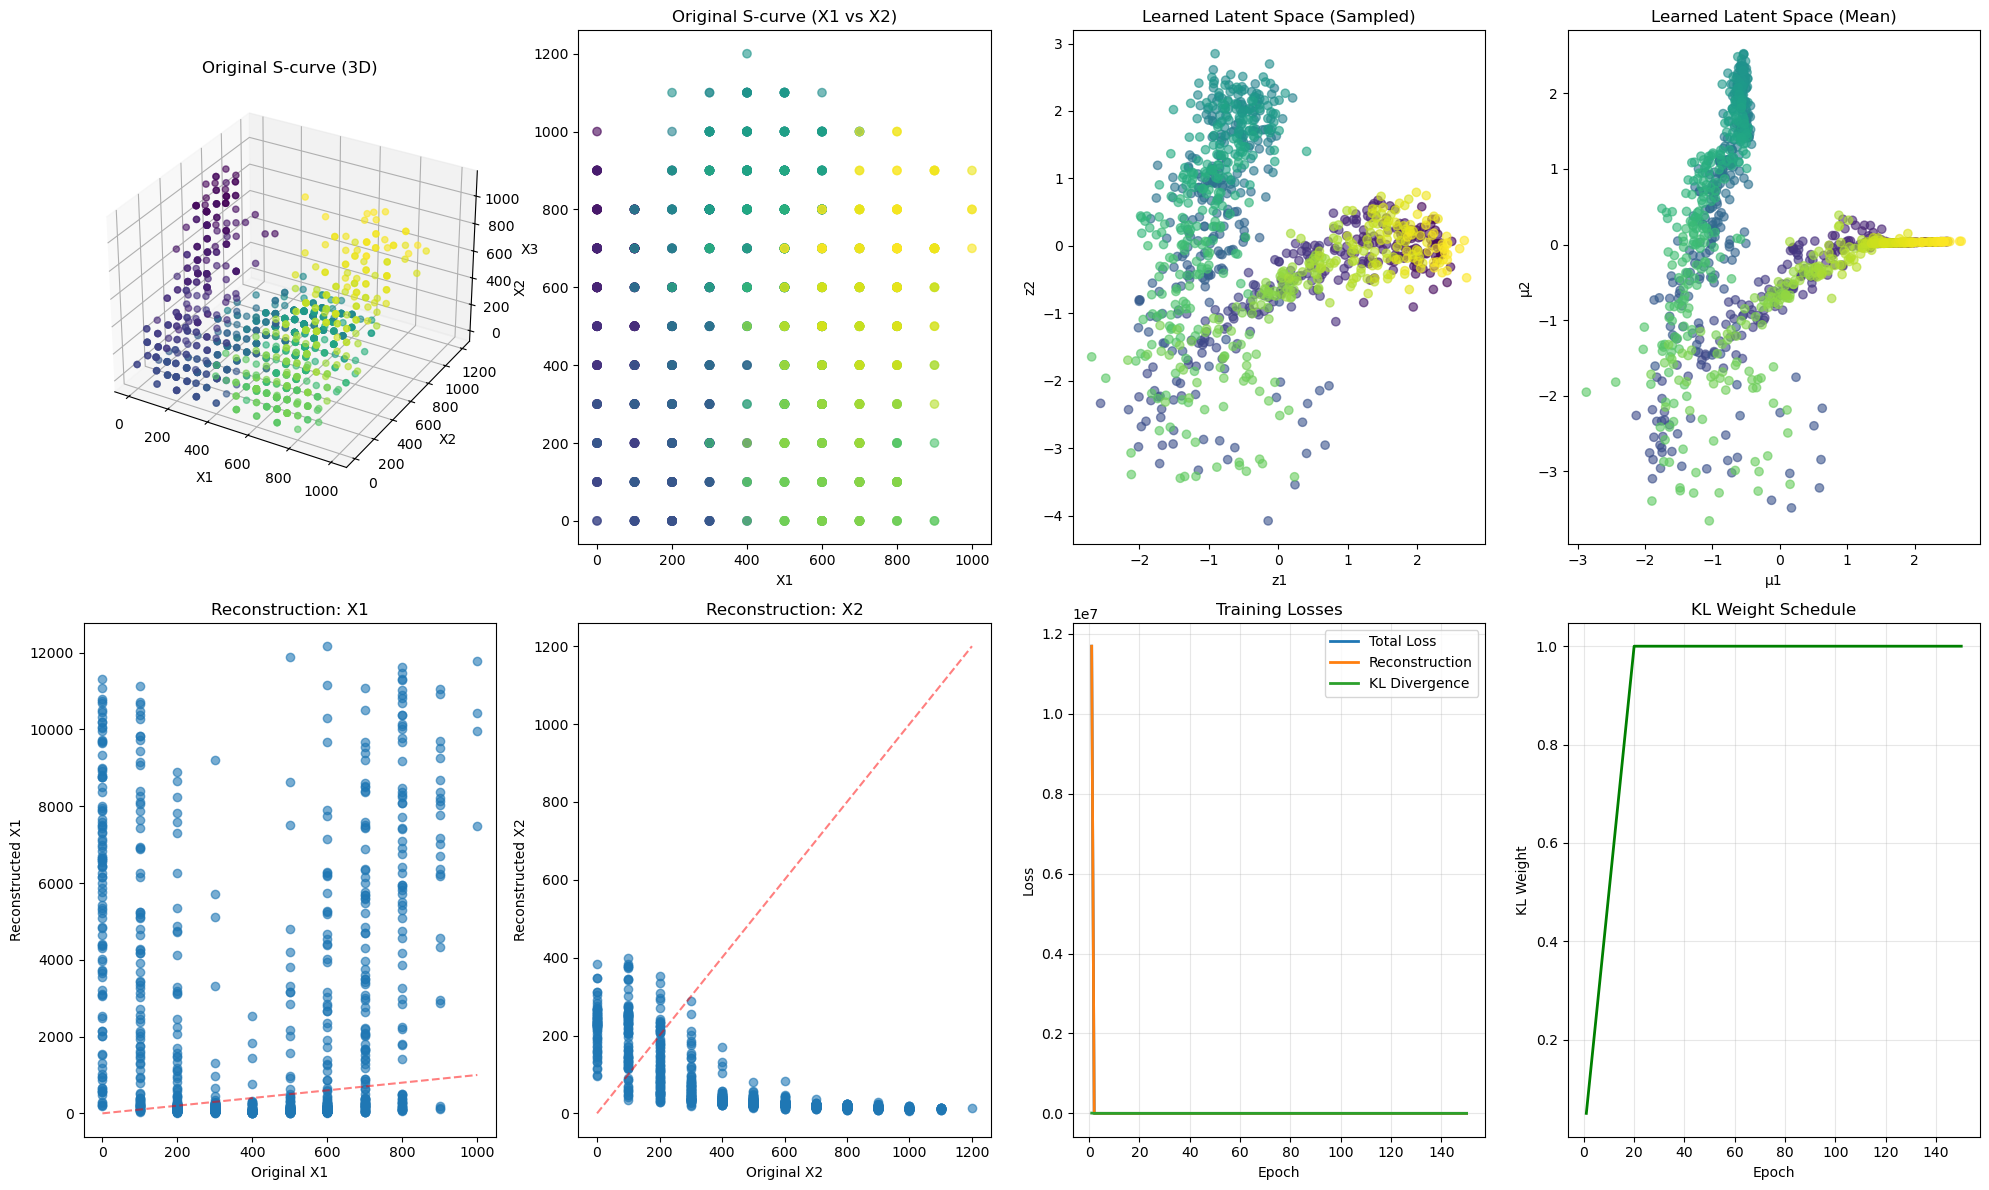


Reconstruction Statistics:
- Mean absolute error: 591.104
- Root mean square error: 1180.910
- Correlation (X1): -0.014
- Correlation (X2): -0.751
- Correlation (X3): -0.747


In [121]:
# --- Visualize VAE Results on S-curve Data ---
print("=== VAE Results Visualization ===\n")

# Extract latent representations
model_s.eval()
with torch.no_grad():
    X_s_device = X_s_tensor.to(device)
    forward_output = model_s(X_s_device)
    z_latent = forward_output['z'].cpu().numpy()
    mu_latent, logvar_latent = model_s._get_latent_params(X_s_device)
    mu_latent = mu_latent.cpu().numpy()
    logvar_latent = logvar_latent.cpu().numpy()

print(f"Latent space statistics:")
print(f"- Latent coordinates range: [{z_latent.min():.3f}, {z_latent.max():.3f}]")
print(f"- Latent mean range: [{mu_latent.min():.3f}, {mu_latent.max():.3f}]")
print(f"- Latent variance range: [{np.exp(logvar_latent).min():.3f}, {np.exp(logvar_latent).max():.3f}]")

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))

# 1. Original S-curve (3D)
ax1 = fig.add_subplot(2, 4, 1, projection='3d')
scatter = ax1.scatter(X_s[:, 0], X_s[:, 1], X_s[:, 2], c=y_s, cmap='viridis', alpha=0.6)
ax1.set_title('Original S-curve (3D)')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('X3')

# 2. Original S-curve (2D projection)
ax2 = fig.add_subplot(2, 4, 2)
ax2.scatter(X_s[:, 0], X_s[:, 1], c=y_s, cmap='viridis', alpha=0.6)
ax2.set_title('Original S-curve (X1 vs X2)')
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')

# 3. Learned latent space (sampled)
ax3 = fig.add_subplot(2, 4, 3)
ax3.scatter(z_latent[:, 0], z_latent[:, 1], c=y_s, cmap='viridis', alpha=0.6)
ax3.set_title('Learned Latent Space (Sampled)')
ax3.set_xlabel('z1')
ax3.set_ylabel('z2')

# 4. Learned latent space (mean)
ax4 = fig.add_subplot(2, 4, 4)
ax4.scatter(mu_latent[:, 0], mu_latent[:, 1], c=y_s, cmap='viridis', alpha=0.6)
ax4.set_title('Learned Latent Space (Mean)')
ax4.set_xlabel('μ1')
ax4.set_ylabel('μ2')

# 5. Reconstruction quality (original vs reconstructed)
model_s.eval()
with torch.no_grad():
    reconstructed = model_s(X_s_device)['px_rate'].cpu().numpy()

ax5 = fig.add_subplot(2, 4, 5)
ax5.scatter(X_s[:, 0], reconstructed[:, 0], alpha=0.6)
ax5.set_title('Reconstruction: X1')
ax5.set_xlabel('Original X1')
ax5.set_ylabel('Reconstructed X1')
ax5.plot([X_s[:, 0].min(), X_s[:, 0].max()], [X_s[:, 0].min(), X_s[:, 0].max()], 'r--', alpha=0.5)

ax6 = fig.add_subplot(2, 4, 6)
ax6.scatter(X_s[:, 1], reconstructed[:, 1], alpha=0.6)
ax6.set_title('Reconstruction: X2')
ax6.set_xlabel('Original X2')
ax6.set_ylabel('Reconstructed X2')
ax6.plot([X_s[:, 1].min(), X_s[:, 1].max()], [X_s[:, 1].min(), X_s[:, 1].max()], 'r--', alpha=0.5)

# 6. Loss curves
ax7 = fig.add_subplot(2, 4, 7)
epochs = [h['epoch'] for h in loss_history]
losses = [h['loss'] for h in loss_history]
recon_losses = [h['recon'] for h in loss_history]
kl_losses = [h['kl'] for h in loss_history]

ax7.plot(epochs, losses, label='Total Loss', linewidth=2)
ax7.plot(epochs, recon_losses, label='Reconstruction', linewidth=2)
ax7.plot(epochs, kl_losses, label='KL Divergence', linewidth=2)
ax7.set_title('Training Losses')
ax7.set_xlabel('Epoch')
ax7.set_ylabel('Loss')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 7. KL weight schedule
ax8 = fig.add_subplot(2, 4, 8)
ax8.plot(epochs, kl_weight_history, 'g-', linewidth=2)
ax8.set_title('KL Weight Schedule')
ax8.set_xlabel('Epoch')
ax8.set_ylabel('KL Weight')
ax8.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print reconstruction statistics
print(f"\nReconstruction Statistics:")
print(f"- Mean absolute error: {np.mean(np.abs(X_s - reconstructed)):.3f}")
print(f"- Root mean square error: {np.sqrt(np.mean((X_s - reconstructed)**2)):.3f}")
print(f"- Correlation (X1): {np.corrcoef(X_s[:, 0], reconstructed[:, 0])[0, 1]:.3f}")
print(f"- Correlation (X2): {np.corrcoef(X_s[:, 1], reconstructed[:, 1])[0, 1]:.3f}")
print(f"- Correlation (X3): {np.corrcoef(X_s[:, 2], reconstructed[:, 2])[0, 1]:.3f}")


=== VAE vs GMVAE Comparison ===

VAE (Standard VAE) Characteristics:
- Prior: N(0, I) - standard Gaussian
- Latent space: 2D for visualization
- KL divergence: Pulls toward standard Gaussian
- No cluster structure in prior

GMVAE (Gaussian Mixture VAE) Characteristics:
- Prior: GMM with fixed means
- Latent space: 1D with mixture components
- KL divergence: Pulls toward mixture components
- Explicit cluster structure in prior

Key Differences for S-curve Data:
1. VAE will learn a smooth 2D representation
2. GMVAE will try to map to discrete 1D clusters
3. VAE better for continuous manifolds (like S-curve)
4. GMVAE better for discrete clusters

VAE Latent Space Analysis:
- Latent space coverage: 6.928
- Latent space center: (-0.109, 0.081)
- Latent space std: (1.224, 1.273)

S-curve Structure Preservation:
- Original S-curve parameter range: [0.000, 1.000]
- Latent space correlation with S-curve parameter:
  - z1 vs S-parameter: -0.017
  - z2 vs S-parameter: -0.014


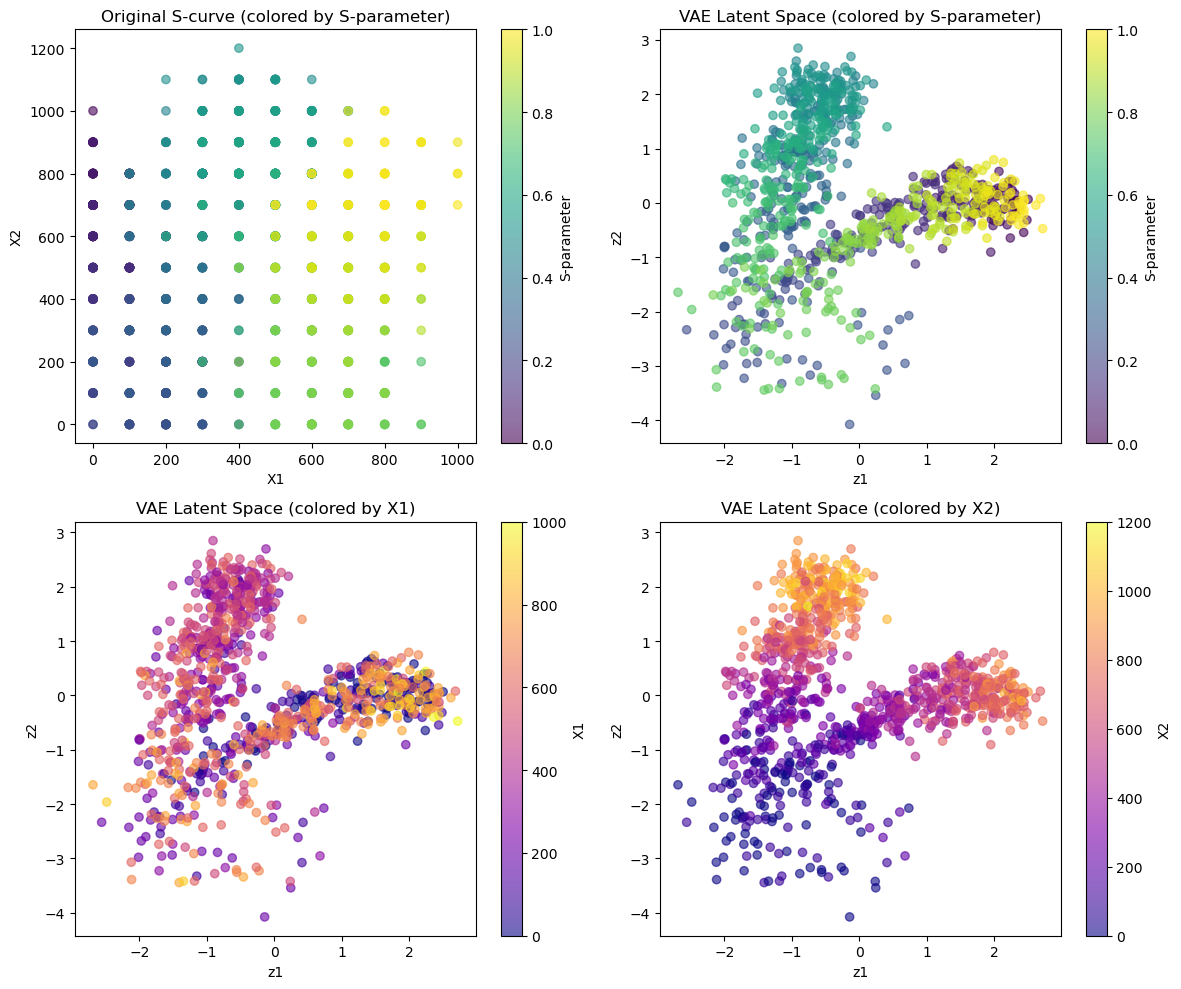


Conclusion:
The VAE successfully learned a 2D latent representation that captures
the S-curve structure, allowing for smooth interpolation and
meaningful dimensionality reduction from 3D to 2D.


In [122]:
# --- Comparison: VAE vs GMVAE on S-curve Data ---
print("=== VAE vs GMVAE Comparison ===\n")

print("VAE (Standard VAE) Characteristics:")
print("- Prior: N(0, I) - standard Gaussian")
print("- Latent space: 2D for visualization")
print("- KL divergence: Pulls toward standard Gaussian")
print("- No cluster structure in prior")
print()

print("GMVAE (Gaussian Mixture VAE) Characteristics:")
print("- Prior: GMM with fixed means")
print("- Latent space: 1D with mixture components")
print("- KL divergence: Pulls toward mixture components")
print("- Explicit cluster structure in prior")
print()

print("Key Differences for S-curve Data:")
print("1. VAE will learn a smooth 2D representation")
print("2. GMVAE will try to map to discrete 1D clusters")
print("3. VAE better for continuous manifolds (like S-curve)")
print("4. GMVAE better for discrete clusters")
print()

# Analyze the learned latent space structure
print("VAE Latent Space Analysis:")
print(f"- Latent space coverage: {z_latent.max() - z_latent.min():.3f}")
print(f"- Latent space center: ({z_latent.mean(axis=0)[0]:.3f}, {z_latent.mean(axis=0)[1]:.3f})")
print(f"- Latent space std: ({z_latent.std(axis=0)[0]:.3f}, {z_latent.std(axis=0)[1]:.3f})")

# Check if the latent space preserves the S-curve structure
print(f"\nS-curve Structure Preservation:")
print(f"- Original S-curve parameter range: [{y_s.min():.3f}, {y_s.max():.3f}]")
print(f"- Latent space correlation with S-curve parameter:")
print(f"  - z1 vs S-parameter: {np.corrcoef(z_latent[:, 0], y_s)[0, 1]:.3f}")
print(f"  - z2 vs S-parameter: {np.corrcoef(z_latent[:, 1], y_s)[0, 1]:.3f}")

# Create a final comparison plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original S-curve colored by parameter
ax1 = axes[0, 0]
scatter1 = ax1.scatter(X_s[:, 0], X_s[:, 1], c=y_s, cmap='viridis', alpha=0.6)
ax1.set_title('Original S-curve (colored by S-parameter)')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
plt.colorbar(scatter1, ax=ax1, label='S-parameter')

# VAE latent space colored by S-parameter
ax2 = axes[0, 1]
scatter2 = ax2.scatter(z_latent[:, 0], z_latent[:, 1], c=y_s, cmap='viridis', alpha=0.6)
ax2.set_title('VAE Latent Space (colored by S-parameter)')
ax2.set_xlabel('z1')
ax2.set_ylabel('z2')
plt.colorbar(scatter2, ax=ax2, label='S-parameter')

# VAE latent space colored by original X1
ax3 = axes[1, 0]
scatter3 = ax3.scatter(z_latent[:, 0], z_latent[:, 1], c=X_s[:, 0], cmap='plasma', alpha=0.6)
ax3.set_title('VAE Latent Space (colored by X1)')
ax3.set_xlabel('z1')
ax3.set_ylabel('z2')
plt.colorbar(scatter3, ax=ax3, label='X1')

# VAE latent space colored by original X2
ax4 = axes[1, 1]
scatter4 = ax4.scatter(z_latent[:, 0], z_latent[:, 1], c=X_s[:, 1], cmap='plasma', alpha=0.6)
ax4.set_title('VAE Latent Space (colored by X2)')
ax4.set_xlabel('z1')
ax4.set_ylabel('z2')
plt.colorbar(scatter4, ax=ax4, label='X2')

plt.tight_layout()
plt.show()

print(f"\nConclusion:")
print(f"The VAE successfully learned a 2D latent representation that captures")
print(f"the S-curve structure, allowing for smooth interpolation and")
print(f"meaningful dimensionality reduction from 3D to 2D.")
